<a href="https://colab.research.google.com/github/akaver/NLP2019/blob/master/Lab13_2019.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Speech Activity Detection

In this lab, we will train a model to perform speech activity detection (SAD), also known as voice activity detection (VAD). The task is to find segments from an audio file where somebody is speaking. It is quite simple for clean audio but could be more complicated if there is a lot of background noise. A SAD module is often used in a larger speech recognition system to avoid feeding data without any speech to the decoder. It is therefore actually a very important submodule and important to get right.

The SAD model is actually quite similar to a DNN acoustic model used in speech recognition systems. The difference is in the number of outpuit classes: SAD has only two output classes (speech and non-speech), whereas a speech recognition acoustic model has typically thousands of output classes, corresponding to tied phone states. But the architectures that work well are similar for both tasks.

We will use a small training dataset with Korean speech in our experiments.

First, we download and unpack the data:

In [0]:
! rm -f sad_data.zip
! wget https://phon.ioc.ee/~tanela/sad_data.zip

--2019-04-23 09:38:21--  https://phon.ioc.ee/~tanela/sad_data.zip
Resolving phon.ioc.ee (phon.ioc.ee)... 193.40.251.126
Connecting to phon.ioc.ee (phon.ioc.ee)|193.40.251.126|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 191045624 (182M) [application/zip]
Saving to: ‘sad_data.zip’

sad_data.zip        100%[===================>] 182.19M  20.0MB/s    in 30s     

2019-04-23 09:38:52 (6.07 MB/s) - ‘sad_data.zip’ saved [191045624/191045624]



In [0]:
! unzip -o sad_data.zip

Archive:  sad_data.zip
   creating: dev_wav/
  inflating: dev_wav/room.wav        
  inflating: dev_wav/construction_site.wav  
  inflating: dev_wav/bus_stop.wav    
  inflating: dev_wav/park.wav        
  inflating: label.dev.txt           
  inflating: label.train.txt         
   creating: train_wav/
  inflating: train_wav/room.wav      
  inflating: train_wav/construction_site.wav  
  inflating: train_wav/bus_stop.wav  
  inflating: train_wav/park.wav      


The dataset contains speech and non-speech from 4 acoustic conditions: room, construction site, bus stop and park. I divided the data into training and dev data. The dev data contains 120 seconds from the end of each recording.

Let's explore the data.

In [0]:
import scipy.io.wavfile as wavfile
import numpy as np

In [0]:
(rate, audio) = wavfile.read("dev_wav/room.wav")

In [0]:
import matplotlib.pyplot as plt
from matplotlib import cm
%matplotlib inline

In [0]:
labels = {}
for l in open("label.dev.txt"):
  spl = l.split()
  labels[spl[0]] = np.array([int(i) for i in spl[1:]])

The label files give the reference classes for the speech data, using 100 frames per second. 0 corresponds to non-speech and 1 to speech.

In [0]:
print(labels)

{'room': array([0, 0, 0, ..., 0, 0, 0]), 'construction_site': array([0, 0, 0, ..., 0, 0, 0]), 'bus_stop': array([1, 1, 1, ..., 1, 1, 1]), 'park': array([1, 1, 1, ..., 0, 0, 0])}


Let's plot the audio and the SAD annotations:

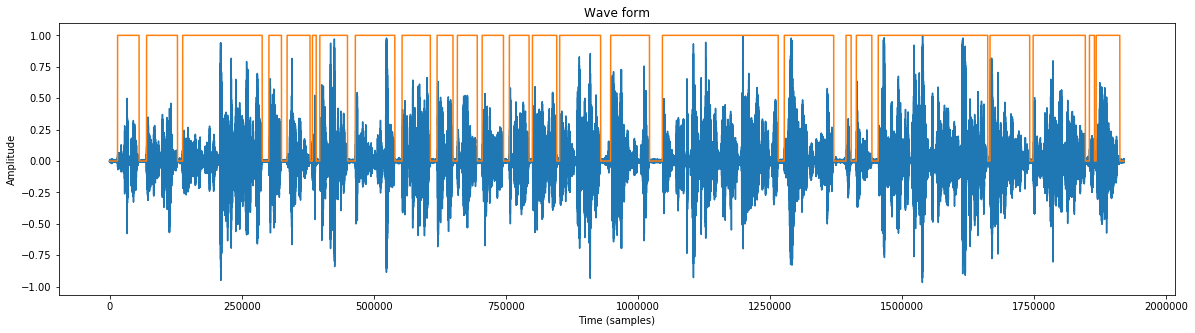

In [0]:
plt.figure(figsize=(20, 5))
plt.title('Wave form')
plt.ylabel('Amplitude')
plt.xlabel('Time (samples)')
plt.plot(audio/np.max(np.abs(audio),axis=0))
# the audio sample rate is 16000 but the label frequency is 100Hz. So we
# need to repeat each label 160 times so that it's in sync with the audio
_ = plt.plot(np.repeat(labels["room"], 160))

Let's try to do the same using extracted features.

In [0]:
! pip install python_speech_features

In [0]:
from python_speech_features import logfbank, mfcc

In [0]:
fbank_feat = logfbank(audio, 16000)

We will display 10 seconds of the dev room data, using filterbank features, together with the labels.

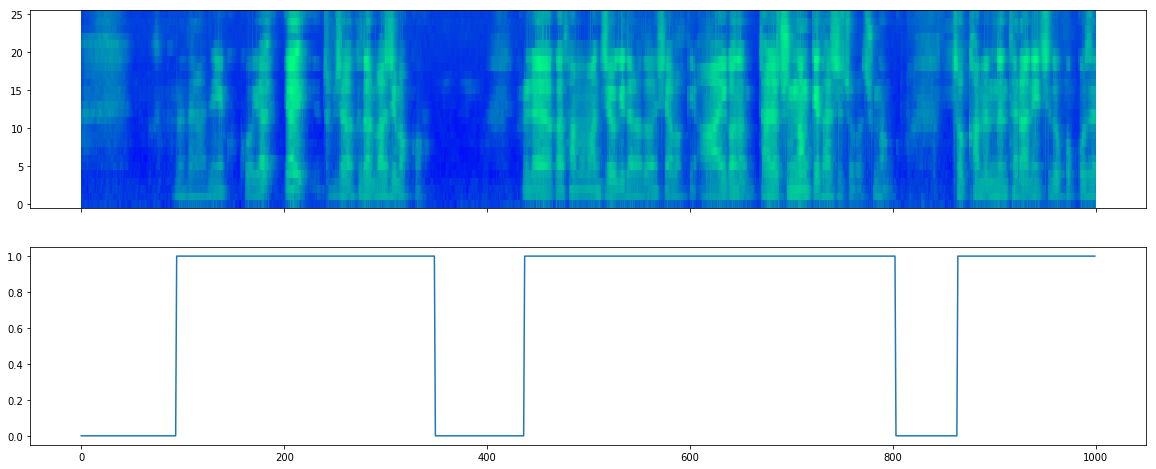

In [0]:
f, axarr = plt.subplots(2, sharex=True, figsize=(20, 8))
axarr[0].imshow(fbank_feat[0:1000].T, origin="lower", aspect='auto', cmap=cm.winter)
axarr[1].plot(labels["room"][0:1000])

We will now implement methods to read all training and dev data.

In [0]:
def read_data(label_file, wav_dir):
  """Read label file and the corresponding audio files.
  """
  labels = {}
  features = {}
  for l in open(label_file):
    spl = l.split()
    wav_id = spl[0]
    # we discard the last label, as the filterbank features are always shorter
    # by one element than the labels (due to the overlapping windows)
    labels[wav_id] = np.array([int(i) for i in spl[1:-1]])
    (rate, audio) = wavfile.read("%s/%s.wav" % (wav_dir, wav_id))
    feat = logfbank(audio, 16000)
    features[wav_id] = feat
  return labels, features    

In [0]:
train_labels, train_features = read_data("label.train.txt", "train_wav")
dev_labels, dev_features = read_data("label.dev.txt", "dev_wav")

In [0]:
print(train_labels["bus_stop"].shape, train_features["bus_stop"].shape)

(168149,) (168149, 26)


Now, we have to convert the data to a form that is suitable for neural network training.

In [0]:
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import sys

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [0]:
class SadDataset(Dataset):
  """The dataset splits the labels and the audio data of a multiple long audio 
  files into shorter segments. For example, into sequences of 50 labels. Extra audio
  data from the left and right is also included, in order to use this as context
  in DNN training.  
  """
  
  def __init__(self, labels, features, seq_len, left_context, right_context):
    self.seq_len = seq_len
    self.left_context = left_context
    self.right_context = right_context
    self.data = []
    for wav_id in labels.keys():
      cur_labels = torch.LongTensor(labels[wav_id])
      cur_features = torch.FloatTensor(features[wav_id])
      p2d = (0, 0, left_context, right_context) # pad last dim by (0, 0) and 2nd to last by (left_context, right_context)
      cur_features = F.pad(cur_features, p2d, 'constant', 0)
      for i in range(len(cur_labels) // seq_len):
        cur_split_labels = cur_labels[i*seq_len : (i+1)*seq_len]
        cur_split_features = cur_features[i*seq_len : (i+1)*seq_len + left_context + right_context]
        self.data.append((cur_split_features, cur_split_labels))

  def __len__(self):
    return len(self.data)

  def __getitem__(self, idx):
    return self.data[idx]        

In [0]:
train_dataset =  SadDataset(train_labels, train_features, 30, 50, 50)
dev_dataset = SadDataset(dev_labels, dev_features, 30, 50, 50)

Let's take a closer look what each element in the resulting dataset corresponds to.

In [0]:
print(dev_dataset[14])

(tensor([[ 6.4667,  5.5913,  5.4580,  ...,  6.3705,  6.4640,  5.7691],
        [ 6.4022,  5.7013,  5.3449,  ...,  6.0591,  5.9789,  5.8625],
        [ 5.8597,  5.5419,  5.7831,  ...,  6.2272,  6.1521,  6.1050],
        ...,
        [ 9.8011, 12.6153, 13.4427,  ...,  6.4138,  7.2086,  6.8966],
        [ 8.5197, 12.6268, 13.6296,  ...,  6.7171,  7.1593,  6.6635],
        [ 8.7187, 12.5409, 13.7171,  ...,  6.8577,  7.0671,  6.8043]]), tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1]))


Each element in the dataset is a tuple (features, labels). Note that the features are "wider", because we used extra left context and right context for them.

In [0]:
print(dev_dataset[14][0].shape, dev_dataset[14][1].shape)

torch.Size([130, 26]) torch.Size([30])


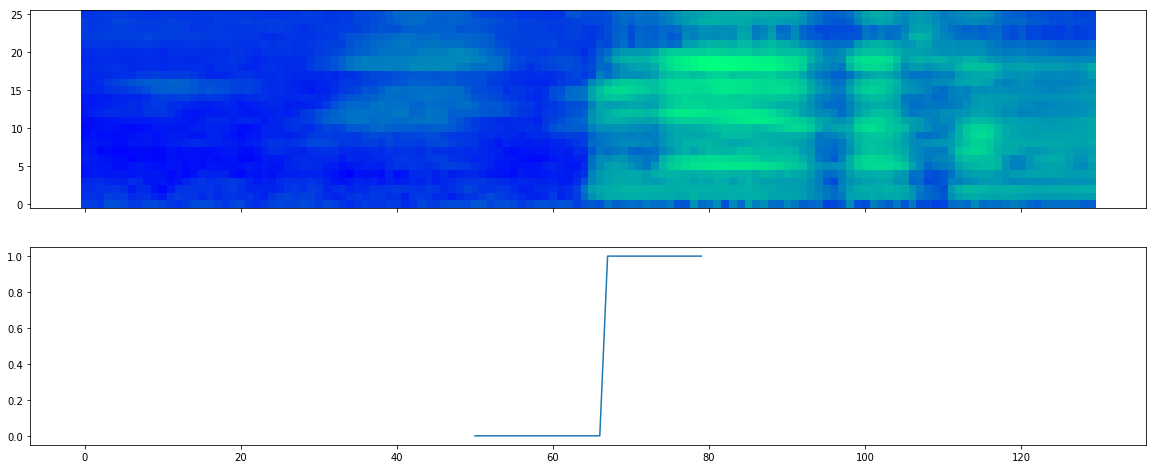

In [0]:
f, axarr = plt.subplots(2, sharex=True, figsize=(20, 8))
axarr[0].imshow(dev_dataset[14][0].transpose(0,1), origin="lower", aspect='auto', cmap=cm.winter)
axarr[1].plot(range(50, 80), dev_dataset[14][1].numpy())

Now it's easy to wrap the datasets into Pytorch data iterator that creates batches from the data.

In [0]:
train_iter = DataLoader(train_dataset, batch_size=32,  shuffle=True)
dev_iter = DataLoader(dev_dataset, batch_size=32,  shuffle=False)

Now we can start building our model. The model that we start with is a basic CNN model.

In [0]:
class SadCnn(nn.Module):
  
  def __init__(self, feature_dim, dropout_prob=0.2):
    super(SadCnn, self).__init__()
    self.input_bn = nn.BatchNorm1d(feature_dim)
    self.conv1 = nn.Conv1d(feature_dim, 32, kernel_size=5, stride=1)
    self.conv2 = nn.Conv1d(32, 64, kernel_size=5, stride=1)
    self.conv3 = nn.Conv1d(64, 64, kernel_size=3, stride=1)
    self.conv4 = nn.Conv1d(64, 64, kernel_size=3, stride=1)
    
    self.fc = nn.Linear(64, 2)
    
  def forward(self, x, seq_length, left_context, right_context):
    # Conv1d takes in (batch, channels, seq_len), but raw signal is (batch, seq_len, channels)
    x = x.permute(0, 2, 1).contiguous()
    x = self.input_bn(x)
    #print(x.shape)
    x = F.relu(self.conv1(x))
    #print(x.shape)
    x = F.relu(self.conv2(x))
    #print(x.shape)
    x = F.relu(self.conv3(x))    
    #print(x.shape)    
    x = F.relu(self.conv4(x))
    #print(x.shape)
    # => (batch, channels, seq_len) => (batch, seq_len, channels)
    x = x.permute(0, 2, 1).contiguous()
    #print(x.shape)
    
    logit = self.fc(x)    
    # Take logits from the middle and ignore the left context and right context, because
    # we calculate the loss only using the midle part.
    # Basically we only take the middle part (of length seq_length) of the resulting logit sequence
    # and ignore the rest (which is now probably a bit smaller than the original left and right
    # context, because the Conv layers work a bit like a pyramid, if we don't explicitly
    # ask them to use padding and edges).
    # This only works if left_context == right_context and if the Conv layers are symmetrical
    logit_seq_len = logit.shape[1]
    assert logit_seq_len > seq_length
    ignore_context = (logit_seq_len - seq_length)//2
    logit = logit[:, ignore_context:-ignore_context, : ]
    return logit

Let's create the model on appropriate device and test if it works. IF the forward method causes
dimension mismatches, try to debug the model by putting print statements after each layer (outcommented above).

In [0]:
model = SadCnn(train_dataset[0][0].shape[1]).to(device)

In [0]:
model.forward(next(iter(dev_iter))[0].to(device), dev_iter.dataset.seq_len, dev_iter.dataset.left_context, dev_iter.dataset.right_context).shape

torch.Size([32, 30, 2])

We can see from the above that at least the dimensionality of the returned logits is correct: batch size is 32, our sequence length is 30, and there are logits for the two output classes.

Next, the train and evaluation methods. They are a bit different from the last week, since now we have to deal with sequences of labels.

In [0]:
def train(model, num_epochs, train_iter, dev_iter, device, log_interval=10):

  optimizer = torch.optim.Adam(model.parameters())

  best_acc = 0
  last_step = 0
  
  for epoch in range(1, num_epochs+1):
    print("Epoch %d" % epoch)
    for batch in train_iter:
      # set training mode
      model.train()
      fbank, targets = batch
      fbank, targets = fbank.to(device), targets.to(device)

      optimizer.zero_grad()
      logits = model(fbank, train_iter.dataset.seq_len, train_iter.dataset.left_context, train_iter.dataset.right_context)
      
      # "flatten" all logits and targets by putting all subsequences together
      flattened_logits = logits.contiguous().view(targets.shape[0] * targets.shape[1], -1)
      flattened_targets = targets.contiguous().view(-1)
      
      loss = F.cross_entropy(flattened_logits, flattened_targets)
      loss.backward()
      optimizer.step()

      
    
    train_acc = evaluate("train", train_iter, model)                
    dev_acc = evaluate("dev", dev_iter, model)                

def evaluate(name, data_iter, model):
  # set evaluation mode (turns off dropout)
  model.eval()
  corrects, avg_loss = 0, 0
  for batch in data_iter:
    fbank, targets = batch
    fbank, targets = fbank.to(device), targets.to(device)
    
    logits = model(fbank, data_iter.dataset.seq_len, data_iter.dataset.left_context, data_iter.dataset.right_context)

    flattened_logits = logits.contiguous().view(targets.shape[0] * targets.shape[1], -1)
    flattened_targets = targets.contiguous().view(-1)

    loss = F.cross_entropy(flattened_logits, flattened_targets)

    avg_loss += loss.item()
    corrects += (torch.max(flattened_logits, 1)[1].view(flattened_targets.size()).data == flattened_targets.data).sum()
    

  size = len(data_iter)
  total_samples = len(data_iter.dataset) * data_iter.dataset.seq_len
  avg_loss /= size
  accuracy = 100.0 * corrects.float()/total_samples
  
  print('Evaluation on {} - loss: {:.6f}  acc: {:.2f}%({}/{})'.format(name,
                                                                     avg_loss, 
                                                                     accuracy, 
                                                                     corrects, 
                                                                     total_samples))
  return accuracy                

In [0]:
model = SadCnn(train_dataset[0][0].shape[1]).to(device)
train(model, 5, train_iter, dev_iter, device=device)

Epoch 1
Evaluation on train - loss: 0.144849  acc: 95.20%(640586/672900)
Evaluation on dev - loss: 0.276198  acc: 90.34%(43256/47880)
Epoch 2
Evaluation on train - loss: 0.127132  acc: 95.92%(645451/672900)
Evaluation on dev - loss: 0.269193  acc: 90.77%(43460/47880)
Epoch 3
Evaluation on train - loss: 0.118265  acc: 96.22%(647469/672900)
Evaluation on dev - loss: 0.334074  acc: 89.69%(42943/47880)
Epoch 4
Evaluation on train - loss: 0.124979  acc: 95.88%(645197/672900)
Evaluation on dev - loss: 0.422590  acc: 86.01%(41181/47880)
Epoch 5
Evaluation on train - loss: 0.110077  acc: 96.51%(649446/672900)
Evaluation on dev - loss: 0.258145  acc: 91.56%(43838/47880)


The resulting accuracy on dev data is a bit over 90% (you might have slightly different results).


Note that if your model is very deep (many layers), then it might be easier to use the Pytorch nn.Sequential class to stack the layers into one list.

The following is equivalent to the model above:

In [0]:
class SadCnn2(nn.Module):
  
  def __init__(self, feature_dim, dropout_prob=0.2):
    super(SadCnn2, self).__init__()
    self.conv_block = nn.Sequential(
      nn.BatchNorm1d(feature_dim),
      nn.Conv1d(feature_dim, 32, kernel_size=5, stride=1),
      nn.ReLU(inplace=True),
      nn.Conv1d(32, 64, kernel_size=5, stride=1),
      nn.ReLU(inplace=True),
      nn.Conv1d(64, 64, kernel_size=3, stride=1),
      nn.ReLU(inplace=True),
      nn.Conv1d(64, 64, kernel_size=3, stride=1),
      nn.ReLU(inplace=True)
    )
    
    self.fc = nn.Linear(64, 2)
    
  def forward(self, x, seq_length, left_context, right_context):
    # Conv1d takes in (batch, channels, seq_len), but raw signal is (batch, seq_len, channels)
    x = x.permute(0, 2, 1).contiguous()
    
    x = self.conv_block(x)
    
    #print(x.shape)
    # => (batch, channels, seq_len) => (batch, seq_len, channels)
    x = x.permute(0, 2, 1).contiguous()
    #print(x.shape)
    
    logit = self.fc(x)    
    logit_seq_len = logit.shape[1]
    assert logit_seq_len > seq_length
    ignore_context = (logit_seq_len - seq_length)//2
    logit = logit[:, ignore_context:-ignore_context, : ]
    return logit

In [0]:
model2 = SadCnn2(train_dataset[0][0].shape[1]).to(device)

In [0]:
train(model2, 5, train_iter, dev_iter, device=device)

Epoch 1
Evaluation on train - loss: 0.161143  acc: 95.21%(640669/672900)
Evaluation on dev - loss: 0.285466  acc: 89.30%(42755/47880)
Epoch 2
Evaluation on train - loss: 0.120139  acc: 96.27%(647829/672900)
Evaluation on dev - loss: 0.258934  acc: 90.85%(43497/47880)
Epoch 3
Evaluation on train - loss: 0.112543  acc: 96.44%(648940/672900)
Evaluation on dev - loss: 0.284687  acc: 90.47%(43317/47880)
Epoch 4
Evaluation on train - loss: 0.114241  acc: 96.31%(648065/672900)
Evaluation on dev - loss: 0.361686  acc: 88.95%(42587/47880)
Epoch 5
Evaluation on train - loss: 0.105922  acc: 96.66%(650440/672900)
Evaluation on dev - loss: 0.251783  acc: 91.14%(43640/47880)


Example of a recurrent model for the same task:

In [0]:
class SadRnn(nn.Module):
  
  def __init__(self, feature_dim, dropout_prob=0.2):
    super(SadRnn, self).__init__()
    self.batchnorm = nn.BatchNorm1d(feature_dim)
    self.rnn = nn.GRU(feature_dim, 100, batch_first=True, bidirectional=True, num_layers=1)
    # the above layer is bidirectional with 100 hidden units, hence the input to
    # the next layer is 200-dimensional
    self.fc = nn.Linear(200, 2)
    
  def forward(self, x, seq_length, left_context, right_context):
    # Conv1d takes in (batch, channels, seq_len), but raw signal is (batch, seq_len, channels)
    x = x.permute(0, 2, 1).contiguous()
    x = self.batchnorm(x)
    x = x.permute(0, 2, 1).contiguous()
    x, _ = self.rnn(x)
    
    #print(x.shape)
    # => (batch, channels, seq_len) => (batch, seq_len, channels)
    #x = x.permute(0, 2, 1).contiguous()
    #print(x.shape)
    
    logit = self.fc(x)    
    logit_seq_len = logit.shape[1]
    assert logit_seq_len > seq_length
    ignore_context = (logit_seq_len - seq_length)//2
    logit = logit[:, ignore_context:-ignore_context, : ]
    return logit

In [0]:
model3 = SadRnn(train_dataset[0][0].shape[1]).to(device)

In [0]:
train(model3, 5, train_iter, dev_iter, device=device)

Epoch 1
Evaluation on train - loss: 0.073711  acc: 97.30%(654723/672900)
Evaluation on dev - loss: 0.214429  acc: 92.00%(44051/47880)
Epoch 2
Evaluation on train - loss: 0.064627  acc: 97.57%(656570/672900)
Evaluation on dev - loss: 0.207115  acc: 91.62%(43870/47880)
Epoch 3
Evaluation on train - loss: 0.060189  acc: 97.82%(658202/672900)
Evaluation on dev - loss: 0.187409  acc: 92.51%(44292/47880)
Epoch 4
Evaluation on train - loss: 0.058650  acc: 97.97%(659218/672900)
Evaluation on dev - loss: 0.174867  acc: 92.98%(44521/47880)
Epoch 5
Evaluation on train - loss: 0.056198  acc: 98.00%(659416/672900)
Evaluation on dev - loss: 0.174824  acc: 92.88%(44471/47880)


## Exercise


*   Implement a model that combines convolutional and RNN layers

